In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import json
import numpy as np
from os.path import expanduser

In [2]:
experiment_name = 'P3856'
feature_detection_method = 'pasef'
run_name = 'P3856_YHE211_1_Slot1-1_1_5104'

RESULTS_BASE_DIR = '/media/data-drive'

IDENTIFICATIONS_WITH_CS_DIR = '{}/P3856-results-cs-true-fmdw-true-2021-05-01-14-59-47/identifications-pasef'.format(RESULTS_BASE_DIR)
IDENTIFICATIONS_WITH_CS_FILE = '{}/exp-{}-identifications-{}-recalibrated.pkl'.format(IDENTIFICATIONS_WITH_CS_DIR, experiment_name, feature_detection_method)

In [3]:
d = pd.read_pickle(IDENTIFICATIONS_WITH_CS_FILE)
idents_df = d['identifications_df']

In [4]:
idents_df = idents_df[idents_df['percolator q-value'] < 0.01]

In [5]:
idents_df.columns

Index(['mono_mz_lower', 'mono_mz_upper', 'scan_apex', 'scan_lower',
       'scan_upper', 'rt_apex', 'rt_lower', 'rt_upper',
       'mono_intensity_without_saturation_correction',
       'mono_intensity_with_saturation_correction',
       'mono_intensity_adjustment_outcome', 'isotopic_peaks', 'scan_df',
       'rt_df', 'monoisotopic_mz', 'charge', 'monoisotopic_mass',
       'feature_intensity', 'envelope', 'isotope_count', 'deconvolution_score',
       'precursor_cuboid_id', 'fragment_ions_l', 'fmdw_before_after_d',
       'feature_id', 'run_name', 'predicted_mass_error',
       'recalibrated_monoisotopic_mass', 'recalibrated_monoisotopic_mz',
       'file_idx', 'spectrum precursor m/z', 'spectrum neutral mass',
       'peptide mass', 'percolator score', 'percolator q-value',
       'percolator PEP', 'total matches/spectrum', 'sequence', 'protein id',
       'flanking aa', 'observed_monoisotopic_mass', 'theoretical_peptide_mass',
       'mass_accuracy_ppm', 'mass_error'],
      dtype='

In [6]:
idents_df.mono_intensity_adjustment_outcome.value_counts(normalize=True) * 100

monoisotopic_not_saturated         95.836660
monoisotopic_saturated_adjusted     4.106308
no_nonsaturated_isotopes            0.034219
could_not_calculate_phr             0.022813
Name: mono_intensity_adjustment_outcome, dtype: float64

In [7]:
# find the precursor id of an ident that has high intensity but was not in saturation
idents_df = idents_df.sort_values(by=['feature_intensity'], ascending=False, inplace=False)
idents_df[(idents_df.mono_intensity_adjustment_outcome == 'monoisotopic_not_saturated')].head(5).precursor_cuboid_id

30      37163
9       41311
240     30283
1658    18003
124     40257
Name: precursor_cuboid_id, dtype: int64

In [8]:
idents_df[(idents_df.mono_intensity_adjustment_outcome == 'monoisotopic_not_saturated')].tail(5).precursor_cuboid_id

67472    40945
63404    37848
68778    30198
63168    36030
73813    27968
Name: precursor_cuboid_id, dtype: int64

In [9]:
idents_df[(idents_df.mono_intensity_adjustment_outcome == 'monoisotopic_saturated_adjusted') & (idents_df.isotope_count > 4)].head(5).precursor_cuboid_id

177     20849
593     42589
258     33209
771     35044
9553    37854
Name: precursor_cuboid_id, dtype: int64

#### select a feature that had its mono in saturation and was adjusted

In [10]:
selected_sequence = idents_df.loc[177]

In [33]:
isotopes_df = pd.DataFrame(selected_sequence.isotopic_peaks)

In [34]:
isotopes_df

,mz,mz_lower,mz_upper,intensity,saturated,inferred_intensity,inferred
0,999.456864,999.425031,999.488696,4665734,True,6295349,True
1,999.958126,999.926278,999.989974,4855693,True,6789304,True
2,1000.459361,1000.427497,1000.491225,3032913,True,3991130,True
3,1000.960993,1000.929113,1000.992873,1339652,True,1671358,True
4,1001.465026,1001.433130,1001.496923,552540,False,552540,False


In [35]:
# Mass difference between Carbon-12 and Carbon-13 isotopes, in Da. For calculating the spacing between isotopic peaks.
CARBON_MASS_DIFFERENCE = 1.003355

In [36]:
# the expected spacing between isotopes in the m/z dimension
expected_spacing_mz = CARBON_MASS_DIFFERENCE / selected_sequence.charge

In [43]:
expected_spacing_mz

0.5016775

In [50]:
isotopes_df['inferred_mz'] = isotopes_df.mz

if (isotopes_df.iloc[0].saturated == True):
    outcome = 'monoisotopic_saturated_adjusted'
    if (len(isotopes_df[isotopes_df.saturated == False]) > 0):
        # find the first unsaturated isotope
        unsaturated_idx = isotopes_df[(isotopes_df.saturated == False)].iloc[0].name
        unsaturated_isotope_mz = isotopes_df.at[unsaturated_idx, 'mz']
        for peak_idx in reversed(range(unsaturated_idx)):
            isotopes_df.at[peak_idx, 'inferred_mz'] = unsaturated_isotope_mz - ((unsaturated_idx - peak_idx) * expected_spacing_mz)
    else:
        outcome = 'no_nonsaturated_isotopes'

In [51]:
isotopes_df

,mz,mz_lower,mz_upper,intensity,saturated,inferred_intensity,inferred,inferred_mz
0,999.456864,999.425031,999.488696,4665734,True,6295349,True,999.458316
1,999.958126,999.926278,999.989974,4855693,True,6789304,True,999.959994
2,1000.459361,1000.427497,1000.491225,3032913,True,3991130,True,1000.461671
3,1000.960993,1000.929113,1000.992873,1339652,True,1671358,True,1000.963349
4,1001.465026,1001.433130,1001.496923,552540,False,552540,False,1001.465026


In [49]:
monoisotope_s = isotopes_df.iloc[0]
mono_mz_shift_ppm = (monoisotope_s.mz - monoisotope_s.inferred_mz) / monoisotope_s.inferred_mz * 10**6
mono_mz_shift_ppm

-1.4535305292755765

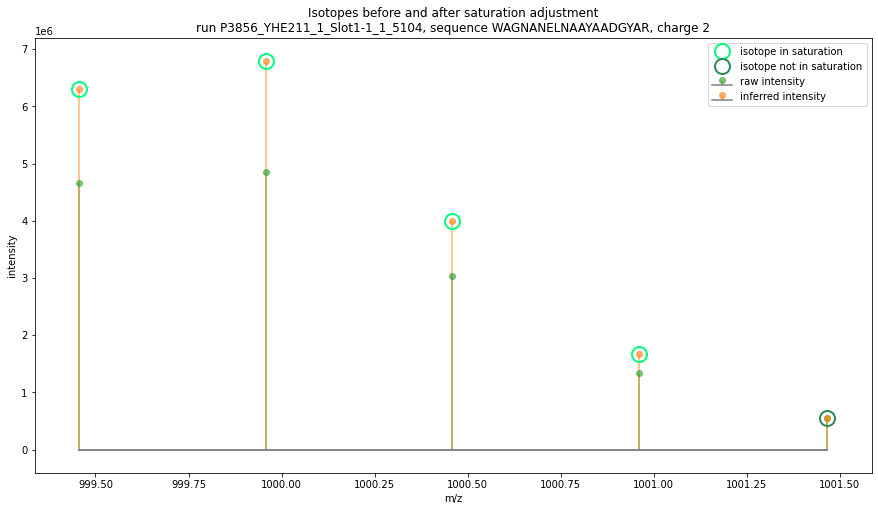

In [13]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

markerline, stemlines, baseline = ax.stem(isotopes_df.mz, isotopes_df.intensity, use_line_collection=True, label='raw intensity')
plt.setp(markerline, 'color', 'tab:green')
plt.setp(stemlines, 'color', 'tab:green')
plt.setp(baseline, 'color', colors[7])
plt.setp(markerline, 'alpha', 0.6)
plt.setp(stemlines, 'alpha', 0.6)

markerline, stemlines, baseline = ax.stem(isotopes_df.mz, isotopes_df.inferred_intensity, use_line_collection=True, label='inferred intensity')
plt.setp(markerline, 'color', 'tab:orange')
plt.setp(stemlines, 'color', 'tab:orange')
plt.setp(baseline, 'color', colors[7])
plt.setp(markerline, 'alpha', 0.6)
plt.setp(stemlines, 'alpha', 0.6)

# highlight the isotopes with inferred intensity
adjusted_intensity_df = isotopes_df[(isotopes_df.inferred == True)]
ax.plot(adjusted_intensity_df.mz, adjusted_intensity_df.inferred_intensity, marker='o', markerfacecolor='none', markeredgecolor='springgreen', linestyle='', markeredgewidth=2, ms=15, label='isotope in saturation')

# highlight the isotopes without inferred intensity
not_adjusted_intensity_df = isotopes_df[(isotopes_df.inferred == False)]
ax.plot(not_adjusted_intensity_df.mz, not_adjusted_intensity_df.inferred_intensity, marker='o', markerfacecolor='none', markeredgecolor='seagreen', linestyle='', markeredgewidth=2, ms=15, label='isotope not in saturation')

plt.xlabel('m/z')
plt.ylabel('intensity')
f.set_figheight(8)
f.set_figwidth(15)
plt.margins(0.06)
plt.legend(loc='best')
plt.title('Isotopes before and after saturation adjustment\nrun {}, sequence {}, charge {}'.format(run_name, selected_sequence.sequence, selected_sequence.charge))
plt.show()

#### distribution of identifications and their monoisotopes in saturation

In [32]:
idents_df.mono_intensity_adjustment_outcome.value_counts(normalize=True) * 100

monoisotopic_not_saturated         95.836660
monoisotopic_saturated_adjusted     4.106308
no_nonsaturated_isotopes            0.034219
could_not_calculate_phr             0.022813
Name: mono_intensity_adjustment_outcome, dtype: float64

#### distribution of isotopes in saturation

In [33]:
df = idents_df[(idents_df.mono_intensity_adjustment_outcome == 'monoisotopic_saturated_adjusted')]

In [35]:
isotope_idxs_l = []
for row in df.itertuples():
    isotopes_df = pd.DataFrame(row.isotopic_peaks)
    nonsat_isotope_idx = isotopes_df[isotopes_df.inferred == False].iloc[0].name
    isotope_idxs_l.append({'isotope_idx_not_in_saturation':nonsat_isotope_idx})
isotope_idxs_df = pd.DataFrame(isotope_idxs_l)

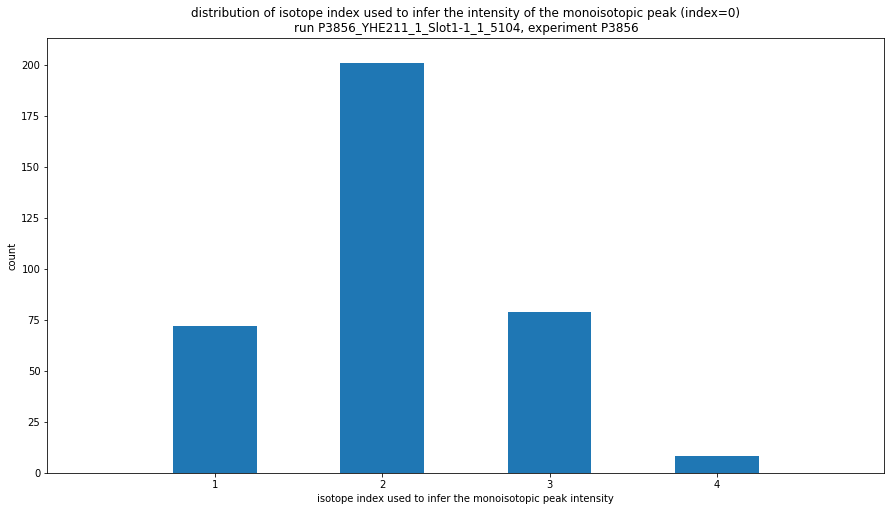

In [37]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

counts = np.bincount(isotope_idxs_df.isotope_idx_not_in_saturation)
ax1.bar(range(isotope_idxs_df.isotope_idx_not_in_saturation.max()+1), counts, width=0.5, align='center')
ax1.set(xticks=range(1,isotope_idxs_df.isotope_idx_not_in_saturation.max()+1), xlim=[0, isotope_idxs_df.isotope_idx_not_in_saturation.max()+1])

plt.xlabel('isotope index used to infer the monoisotopic peak intensity')
plt.ylabel('count')
plt.title('distribution of isotope index used to infer the intensity of the monoisotopic peak (index=0)\nrun {}, experiment {}'.format(run_name, experiment_name))

plt.show()